In [1]:
# Imports
import numpy as np
import pandas as pd
import os

import email
from email import policy
from bs4 import BeautifulSoup

In [2]:
# Print size of data
print("Size of Spam Data:", len(os.listdir('./Data/archive/spam/')))
print("Size of Ham Data:", len(os.listdir('./Data/archive/ham/')))

Size of Spam Data: 501
Size of Ham Data: 2551


In [3]:
# Import Raw Data

directory = './Data/archive/'

contents = []
subject = []
labels = []
fromSenders = []

error = 0
wrongContentType = 0

def payloadToContent(payload):
    finalContent = ""
    for i in range(len(payload)):
        try:
            if(isinstance(payload[i], str)):
                finalContent += payload[i]
            elif payload[i].get_content_type() == 'text/plain':
                finalContent += payload[i].get_content()
            elif payload[i].get_content_type() == 'text/html':
                finalContent += BeautifulSoup(payload[i].get_content()).body.text
            elif "multipart" in payload[i].get_content_type():
                finalContent += payloadToContent(payload[i].get_payload())
        except LookupError:
            pass
    return finalContent

for label in ['ham/', 'spam/']:
    labelDirectory = os.listdir(directory + label)
    for file in labelDirectory:
        with open((directory + label + file), 'rb') as file:
            email_file = email.parser.BytesParser(policy=email.policy.default).parse(file)
            try:
                
                if email_file.get_content_type() == 'text/plain':
                    contents.append(email_file.get_content())
                elif email_file.get_content_type() == 'text/html':
                    contents.append(BeautifulSoup(email_file.get_content()).body.text)
                elif email_file.get_content_type() in ['multipart/signed', 'multipart/mixed', 'multipart/report', 'multipart/related', 'multipart/alternative']:
                    contents.append(payloadToContent(email_file.get_payload()))
                else:
                    wrongContentType += 1
                    continue
                subject.append(email_file['Subject'] or "")
                labels.append(label)
                fromSenders.append(email_file['From'] or "")
            except LookupError:
                error +=1
                pass
            
print("Read Email Content Errors: " + str(error))
print("Wrong Email Content Type: " + str(wrongContentType))

Read Email Content Errors: 3
Wrong Email Content Type: 0


In [4]:
# Convert to Dataframe
df = pd.DataFrame({'subject': subject, 'content': contents, 'label': labels, 'from': fromSenders})

In [5]:
# Look at example email - we can see it contains headers, sender & content
df.iloc[0].subject

'Re: New Sequences Window'

In [6]:
# Check for imported null values in our data that could ruin it
df.isnull().sum()

subject    0
content    0
label      0
from       0
dtype: int64

In [7]:
# Encode "spam/" & "ham/" to 0 & 1
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

In [8]:
# Convert email content to lowercase (Casing of words shouldn't effect spam or not)
# Item 2 we can see \n for newline, there might also be \t for tab or \r for return
# New lines won't add much value so lets replace them with space instead
columnArray = ['content', 'from', 'subject']
for column in columnArray:
    df[column] = df[column].apply(lambda x:x.lower())
    df[column] = df[column].apply(lambda x: x.replace('\n', ' '))
    df[column] = df[column].apply(lambda x: x.replace('\t', ' '))
    df[column] = df[column].apply(lambda x: x.replace('\r', ' '))
    
df.head()

,subject,content,label,from
0,re: new sequences window,"date: wed, 21 aug 2002 10:54:46 -05...",0,robert elz <kre@munnari.oz.au>
1,[zzzzteana] re: alexander,"martin a posted: tassos papadopoulos, the gree...",0,steve burt <steve_burt@cursor-system.com>
2,[zzzzteana] moscow bomber,man threatens explosion in moscow thursday a...,0,tim chapman <timc@2ubh.com>
3,[irr] klez: the virus that won't die,klez: the virus that won't die already the m...,0,monty solomon <monty@roscom.com>
4,re: insert signature,"on wed aug 21 2002 at 15:46, ulises ponce wrot...",0,tony nugent <tony@linuxworks.com.au>


In [9]:
# Stemming - Find the root of every word
import nltk #Natural Language Toolkit
nltk.download('stopwords')

import re #Regular Expression
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

ps = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgaud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Needs to do this 3051 times - takes a while 5 mins - implemented progress bar
from ipywidgets import IntProgress
from IPython.display import display

f = IntProgress(min=0, max=len(df)) # instantiate the bar
display(f) # display the bar

processedContent = []
processedFrom = []
processedSubject = []

for i in range(len(df)):
    f.value = i
    for column in columnArray:
        # Remove special charactors & numbers - uses Regex
        review = re.sub('[^a-zA-Z]', ' ', df[column][i])
        review = review.split()
        # Get the stem of the word if the word is not in StopWords
        # Stop words include a, on, at, to, and ... 
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        if(column == 'content'):
            processedContent.append(review)
        elif(column == 'from'):
            processedFrom.append(review)
        elif(column == 'subject'):
            processedSubject.append(review)
            
#combined = []
#for i in range(len(processedContent)):
#    combined.append(processedContent[i] + " " + processedFrom[i] + " " + processedSubject[i])

IntProgress(value=0, max=3049)

In [24]:
# Using "Bag of Words" - converts the count of words to a simple vector
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 3000) # Number of words to use in "Bag of Words"
X1 =  cv.fit_transform(processedContent).toarray()
X2 =  cv.fit_transform(processedFrom).toarray()
X3 =  cv.fit_transform(processedSubject).toarray()
X = np.concatenate((X1, X2, X3), axis=1) 
y = df['label']
#print("Content: Bag of Words Length: " + str(len(a)))
#print("From: Bag of Words Length: " + str(len(b)))
#print("Subject: Bag of Words Length: " + str(len(c)))
#print("Bag of Words Total Length: " + str(len(X)))

In [25]:
# Split Data into Train & Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [26]:
# Algorithm - MultiNomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

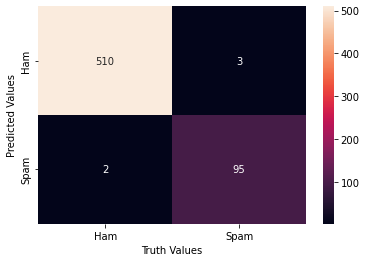

Accuracy: 99.18%
Precision: 96.94%
Recall: 97.94%
F1 score: 97.44%


In [27]:
# Metrics - MultiNomial Naive Bayes
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred)

#matrix_df = pd.DataFrame(matrix, index=["Ham", "Spam"], columns=["Ham", "Spam"])
#confusion_df = matrix_df.astype('float')/matrix_df.sum(axis=1)
s = sns.heatmap(matrix, annot=True, fmt='.3g', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
s.set(xlabel='Truth Values', ylabel='Predicted Values')
plt.show()


print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))
print("F1 score: {:.2f}%".format(100 * f1_score(y_test, y_pred)))